# About

This notebook is for the computation of various quantities from the protein simulations.

# Data Collection Utilities 

Since we need to use GROMACS scripts command line, there's some utilities built up here to collect the data.

In [1]:
import signac
import subprocess
import pexpect
import flowproject
import tqdm
import numpy as np
import pandas as pd

## Define constants as needed

In [2]:
def clear_xvg(project, glob = '*.xvg*', debug = False):
    """Delete all xvg files"""
    cmd = "find {} -name {} -exec rm {{}} \;".format(project.workspace(), glob)
    if debug:
        print("Trying to run the following command: {}".format(cmd))
    else:
        return subprocess.check_output("find {} -name {} -exec rm {{}} \;".format(project.workspace(), glob), shell = True)

def gromacs_interactive_calc(job, cmd, expects = [], responses = [], display = False):
    """Perform a GROMACS calculation that requires
    command line interaction using the pexpect utility
    
    job (Job): signac job to run on 
    cmd (str): Command to run
    expects (list): List of text to respond to
    responses (list): Responses to expected text, same length as expects
    """
    with job:
        child = pexpect.spawn(cmd)
        
        # Run through all expected text
        for i in range(len(expects)):
            child.expect(expects[i])
            child.send(responses[i] + '\n')
            if display:
                print(child.before.decode('ascii'))
                print(child.after.decode('ascii'))
                
        # Terminate run
        child.expect(pexpect.EOF)
        if display:
            print(child.before.decode('ascii')) 

In [3]:
project = signac.get_project()
# Regenerate files if necessary
for job in tqdm.tqdm_notebook(project):
    # Generate total RMS if possible
    if job.isfile('md.trr') and not job.isfile('rmsd_xtal.xvg'):
            gromacs_interactive_calc(job, "{} rms -s em.tpr -f md.xtc -o rmsd_xtal.xvg -xvg none -tu ns".format(gmx),
                                    ["Select a group:*", "Select a group:*"],
                                    ["4", "4"])
            
    
    # Energy minimization has completed, can check the output to see if minimization worked.
    if job.isfile('em.edr') and not job.isfile('potential_em.xvg'):
        gromacs_interactive_calc(job, "gmx_mpi energy -f em.edr -o potential_em.xvg -xvg none",
                                 ['End your selection with an empty line or a zero.*'],
                                 ['12 0'])
        
    # Get final potential energies for everything so that we can see
    # how the energy behaves under different circumstances
    if job.isfile('md.edr') and not job.isfile('potential_md.xvg'):
        gromacs_interactive_calc(job, "gmx_mpi energy -f md.edr -o potential_md.xvg -xvg none",
                                 ['End your selection with an empty line or a zero.*'],
                                 ['12 0'])
        
    if job.isfile('md.edr') and not job.isfile('coulomb_md.xvg'):
        gromacs_interactive_calc(job, "gmx_mpi energy -f md.edr -o coulomb_md.xvg -xvg none",
                                 ['End your selection with an empty line or a zero.*'],
                                 ['8 0'])
        
    if job.isfile('md.edr') and not job.isfile('lj_md.xvg'):
        gromacs_interactive_calc(job, "gmx_mpi energy -f md.edr -o lj_md.xvg -xvg none",
                                 ['End your selection with an empty line or a zero.*'],
                                 ['6 0'])
    
    # Checks on equilibration
    if job.isfile('nvt.edr') and not job.isfile('temperature.xvg'):
        gromacs_interactive_calc(job, "gmx_mpi energy -f nvt.edr -o temperature.xvg -xvg none",
                                 ['End your selection with an empty line or a zero.*'],
                                 ['15 0'])
    if job.isfile('npt.edr') and not job.isfile('pressure.xvg'):
        gromacs_interactive_calc(job, "gmx_mpi energy -f npt.edr -o pressure.xvg -xvg none",
                                 ['End your selection with an empty line or a zero.*'],
                                 ['16 0'])

# Analyzing outputs

## RMSD

Compare the outputs

In [4]:
salts = []
pos_seg_opts = []
seg_inds = []
rmsds = []
rotations = []

for job in tqdm.tqdm_notebook(project):
    if job.isfile('rmsd_xtal.xvg'):
        with job:
            rmsd = np.genfromtxt("rmsd_xtal.xvg")[-1, -1]
            if job.sp.positive_segments not in pos_seg_opts:
                ind = len(pos_seg_opts)
                pos_seg_opts.append(job.sp.positive_segments)
            else:
                ind = pos_seg_opts.index(job.sp.positive_segments)
        salts.append(job.sp.salt_concentration)
        seg_inds.append(ind)
        rmsds.append(rmsd)
        rotations.append(job.sp.rotation)

In [5]:
df_rotation = pd.DataFrame(dict(
    salt_conc = salts,
    seg_inds = seg_inds,
    rmsds = rmsds
))
print(df_rotation.groupby('salt_conc')['rmsds'].mean())

salt_conc
0.02    0.941171
0.05    0.808089
0.10    0.766783
0.15    0.780073
0.20    0.803889
Name: rmsds, dtype: float64


## Find jobs that didn't proceed past equilibration

## Potential Energy

In [6]:
salts = []
pos_seg_opts = []
seg_inds = []
potentials = []
coulombs = []
ljs = []
rotations = []

for job in tqdm.tqdm_notebook(project):
    if job.isfile('md.edr'):
        with job:
            V = np.genfromtxt("potential_md.xvg")[-1, -1]
            C = np.genfromtxt("coulomb_md.xvg")[-1, -1]
            LJ = np.genfromtxt("lj_md.xvg")[-1, -1]
            if job.sp.positive_segments not in pos_seg_opts:
                ind = len(pos_seg_opts)
                pos_seg_opts.append(job.sp.positive_segments)
            else:
                ind = pos_seg_opts.index(job.sp.positive_segments)
        salts.append(job.sp.salt_concentration)
        seg_inds.append(ind)
        potentials.append(V)
        coulombs.append(C)
        ljs.append(LJ)
        rotations.append(job.sp.rotation)

In [7]:
df_energy = pd.DataFrame(dict(
    salt_conc = salts,
    seg_ind = seg_inds,
    rotation = rotations,
    potential = potentials,
    coul = coulombs,
    lj = ljs
))
print(df_energy.groupby('salt_conc').mean())

                   coul            lj     potential   rotation   seg_ind
salt_conc                                                               
0.02      -1.377501e+07  1.914693e+06 -1.054951e+07  54.000000  1.650000
0.05      -1.392293e+07  1.929495e+06 -1.068210e+07  65.000000  1.600000
0.10      -1.406576e+07  1.934431e+06 -1.081895e+07  53.333333  1.533333
0.15      -1.417531e+07  1.932904e+06 -1.092918e+07  60.000000  1.619048
0.20      -1.433825e+07  1.940746e+06 -1.108300e+07  58.666667  1.533333


## Identify Segment with all

For inspection it's useful to have one protomer configuration for which all salt concentrations succeeded.
This cell helps me identify one such configuration and see some basic properties, and then I can look at the files.

In [8]:
df_energy[(df_energy['seg_ind'] == 1) & (df_energy['rotation'] == 0)]

coul           lj   potential  rotation  salt_conc  seg_ind
27 -14005686.0  1938722.875 -10755601.0         0       0.05        1
51 -14324913.0  1957861.375 -11055110.0         0       0.15        1
63 -13913640.0  1937739.375 -10665240.0         0       0.02        1
78 -14166422.0  1953172.375 -10899988.0         0       0.10        1
80 -14471691.0  1959238.125 -11197780.0         0       0.20        1

In [9]:
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
df_index = pd.DataFrame(statepoints).T.join(df_index)
df_selected = df_index[(df_index['rotation'] == 0) & (
    df_index.apply(lambda row: row[df_index.columns[1]] == pos_seg_opts[1], axis = 1)
)]
df_selected[df_selected['salt_concentration'].isin([0.02, 0.2])]

negative_segments  \
73bca573ac481d545a534d4140b3f985  [102, 104, 109, 107, 108, 99, 103, 105]   
a891a5ce30673845c69c24f61957f051  [102, 104, 109, 107, 108, 99, 103, 105]   

                                                     positive_segments  \
73bca573ac481d545a534d4140b3f985  [106, 86, 93, 101, 87, 100, 110, 83]   
a891a5ce30673845c69c24f61957f051  [106, 86, 93, 101, 87, 100, 110, 83]   

                                 rotation salt_concentration  restrained  \
73bca573ac481d545a534d4140b3f985        0                0.2        True   
a891a5ce30673845c69c24f61957f051        0               0.02        True   

                                                                               root  \
73bca573ac481d545a534d4140b3f985  /nfs/turbo/glotz-aro-prtn/protein-xtals/vyas/g...   
a891a5ce30673845c69c24f61957f051  /nfs/turbo/glotz-aro-prtn/protein-xtals/vyas/g...   

                                                         signac_id  \
73bca573ac481d545a534d4140b3f985  73bca573ac481d545a534d4140b3f985   
a891a5ce30673845c69c24f61957f051  a891a5ce30673845c69c24f61957f051   

                                                                         statepoint  \
73bca573ac481d545a534d4140b3f985  {'negative_segments': [102, 104, 109, 107, 108...   
a891a5ce30673845c69c24f61957f051  {'negative_segments': [102, 104, 109, 107, 108...   

                                                                             status  
73bca573ac481d545a534d4140b3f985  {'73bca573ac481d545a534d4140b3f985-npt': 1, '7...  
a891a5ce30673845c69c24f61957f051  {'a891a5ce30673845c69c24f61957f051-npt': 1, 'a...

## Compare different configurations
Here we look at the potential energy landscape for different protomer configurations, all at the same (low) salt concentration.
First identify such a concentration, then we inspect.

In [10]:
df_energy.columns

Index(['coul', 'lj', 'potential', 'rotation', 'salt_conc', 'seg_ind'], dtype='object')

In [11]:
df_energy[df_energy['rotation'] == 0].groupby(['salt_conc']).count()
# Identifies rotation 0, 0.02 conc


coul  lj  potential  rotation  seg_ind
salt_conc                                        
0.02          4   4          4         4        4
0.05          2   2          2         2        2
0.10          2   2          2         2        2
0.15          3   3          3         3        3
0.20          3   3          3         3        3

In [12]:
ids = []
seg_inds = []
pots = []
rotations = []

for job in tqdm.tqdm_notebook(project):
    if job.isfile('potential_md.xvg') and job.sp.salt_concentration == 0.02:
        with job:
            pot = np.genfromtxt("potential_md.xvg")[-1, -1]
            if job.sp.positive_segments not in pos_seg_opts:
                ind = len(pos_seg_opts)
                pos_seg_opts.append(job.sp.positive_segments)
            else:
                ind = pos_seg_opts.index(job.sp.positive_segments)
        ids.append(job.get_id())
        seg_inds.append(ind)
        pots.append(pot)
        rotations.append(job.sp.rotation)

In [13]:
df_energy_compare = pd.DataFrame(dict(
    id = ids,
    seg_inds = seg_inds,
    potential = pots,
    rotations = rotations
))
(df_energy_compare['potential'].max() - df_energy_compare['potential'].min())/df_energy_compare['potential'].min()

-0.07355092281325043

In [14]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.hist(df_energy_compare['potential'])

(array([ 9.,  1.,  7.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-10688078. , -10609466.2, -10530854.4, -10452242.6, -10373630.8,
        -10295019. , -10216407.2, -10137795.4, -10059183.6,  -9980571.8,
         -9901960. ]),
 <a list of 10 Patch objects>)

There appears to be one particular configuration that is much less favorable than the others.
Aside from that one, however, the difference between the other jobs

**TODO: Investigate that one job further**

In [15]:
project.open_job(id = 'c3fce').statepoint()

{'negative_segments': [102, 104, 109, 107, 108, 99, 103, 105],
 'positive_segments': [106, 86, 93, 101, 87, 100, 110, 83],
 'rotation': 60,
 'salt_concentration': 0.02}

In [16]:
df_energy_compare[df_energy_compare['potential'] == df_energy_compare['potential'].min()]

id   potential  rotations  seg_inds
12  c3fceab53355c366d0d7678d83f1526f -10688078.0         60         1

# Testing

The jobs that I'm currently comparing are the two above (73bca, a891a), which only differ by having an order of magnitude difference in salt concentration.

## Minimization 

<IPython.core.display.Javascript object>


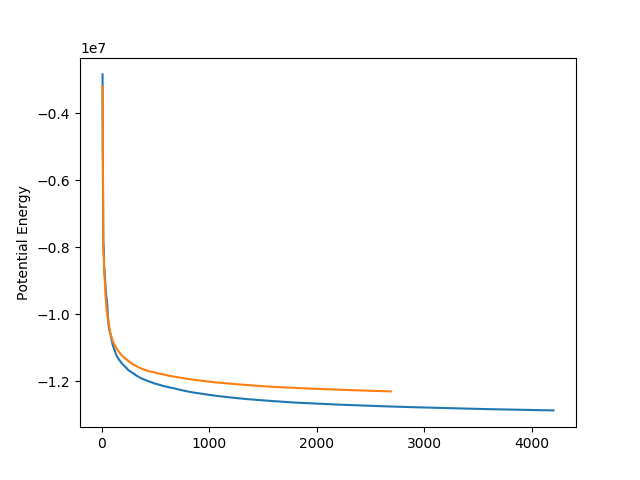

In [19]:
from matplotlib import pyplot as plt
%matplotlib notebook
project = signac.get_project()
fig, ax = plt.subplots(1, 1)
start_index = 7
with project.open_job(id = '73bca') as job:
    data = np.genfromtxt('potential_em.xvg')
    ax.plot(data[start_index:, 0], data[start_index:, 1])
    ax.set_ylabel('Potential Energy')
with project.open_job(id = 'a891a') as job:
    data = np.genfromtxt('potential_em.xvg')
    ax.plot(data[start_index:, 0], data[start_index:, 1])

## NVT Equilibration

<IPython.core.display.Javascript object>


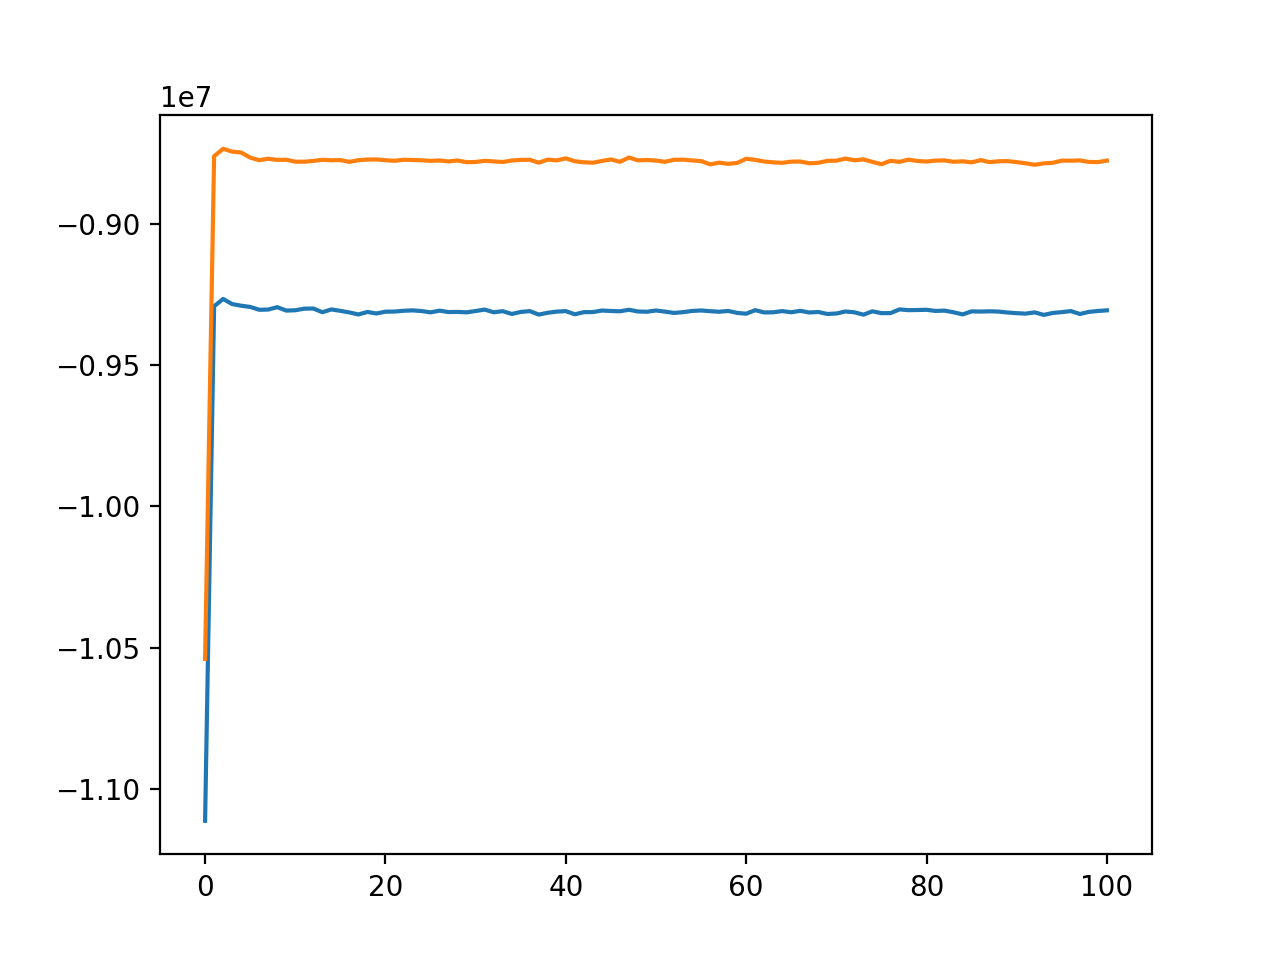

In [22]:
from matplotlib import pyplot as plt
%matplotlib notebook
project = signac.get_project()
fig, ax = plt.subplots(1, 1)
start_index = 0
with project.open_job(id = '73bca') as job:
    data = np.genfromtxt('temperature.xvg')
    ax.plot(data[start_index:, 0], data[start_index:, 1])
    ax.set_ylabel('System Volume (nm^2)')
with project.open_job(id = 'a891a') as job:
    data = np.genfromtxt('temperature.xvg')
    ax.plot(data[start_index:, 0], data[start_index:, 1])

## NPT Equilibration

<IPython.core.display.Javascript object>


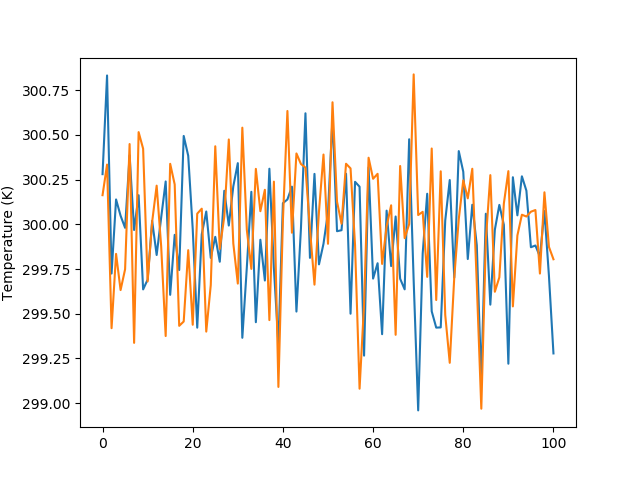

In [20]:
from matplotlib import pyplot as plt
%matplotlib notebook
project = signac.get_project()
fig, ax = plt.subplots(1, 1)
start_index = 0
with project.open_job(id = '73bca') as job:
    data = np.genfromtxt('pressure.xvg')
    ax.plot(data[start_index:, 0], data[start_index:, 1])
    ax.set_ylabel('Temperature (K)')
with project.open_job(id = 'a891a') as job:
    data = np.genfromtxt('pressure.xvg')
    ax.plot(data[start_index:, 0], data[start_index:, 1])

## Potential energy over time

<IPython.core.display.Javascript object>


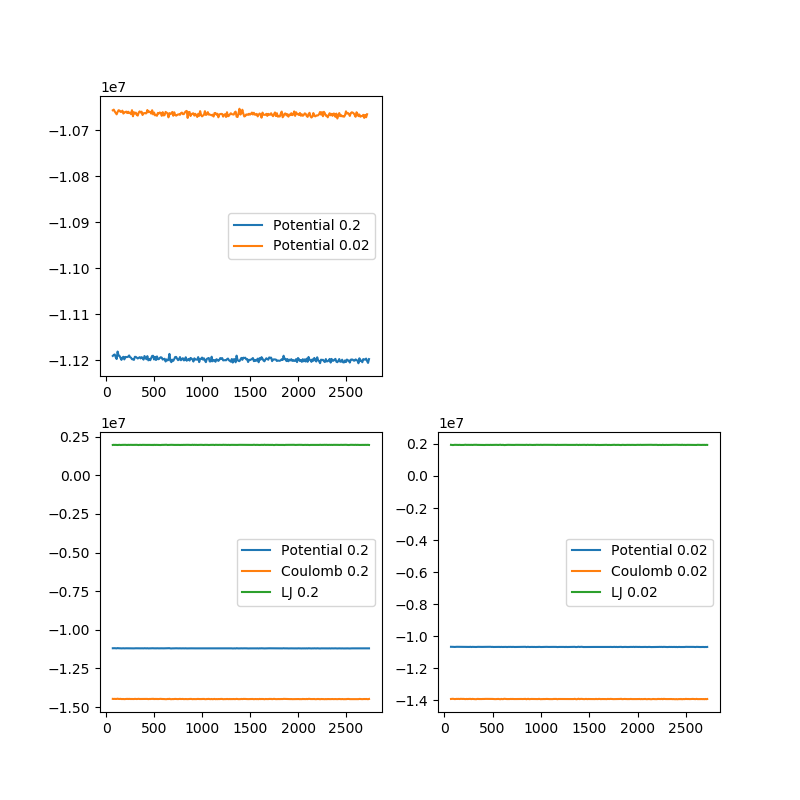

In [12]:
from matplotlib import pyplot as plt
%matplotlib notebook
project = signac.get_project()
with project.open_job(id = '73bca') as job:
    potential_higher = np.genfromtxt('potential_md.xvg')
    coulomb_higher = np.genfromtxt('coulomb_md.xvg')
    lj_higher = np.genfromtxt('lj_md.xvg')
with project.open_job(id = 'a891a') as job:
    potential_lower = np.genfromtxt('potential_md.xvg')
    coulomb_lower = np.genfromtxt('coulomb_md.xvg')
    lj_lower = np.genfromtxt('lj_md.xvg')
    
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
start_index = 7

axes[0, 0].plot(potential_higher[start_index:, 0], potential_higher[start_index:, 1], label = 'Potential 0.2')
axes[0, 0].plot(potential_lower[start_index:, 0], potential_lower[start_index:, 1], label = 'Potential 0.02')
axes[0, 0].legend()

axes[0, 1].axis('off')

axes[1, 0].plot(potential_higher[start_index:, 0], potential_higher[start_index:, 1], label = 'Potential 0.2')
axes[1, 0].plot(coulomb_higher[start_index:, 0], coulomb_higher[start_index:, 1], label = 'Coulomb 0.2')
axes[1, 0].plot(lj_higher[start_index:, 0], lj_higher[start_index:, 1], label = 'LJ 0.2')
axes[1, 0].legend()

axes[1, 1].plot(potential_lower[start_index:, 0], potential_lower[start_index:, 1], label = 'Potential 0.02')
axes[1, 1].plot(coulomb_lower[start_index:, 0], coulomb_lower[start_index:, 1], label = 'Coulomb 0.02')
axes[1, 1].plot(lj_lower[start_index:, 0], lj_lower[start_index:, 1], label = 'LJ 0.02')
axes[1, 1].legend()

<IPython.core.display.Javascript object>


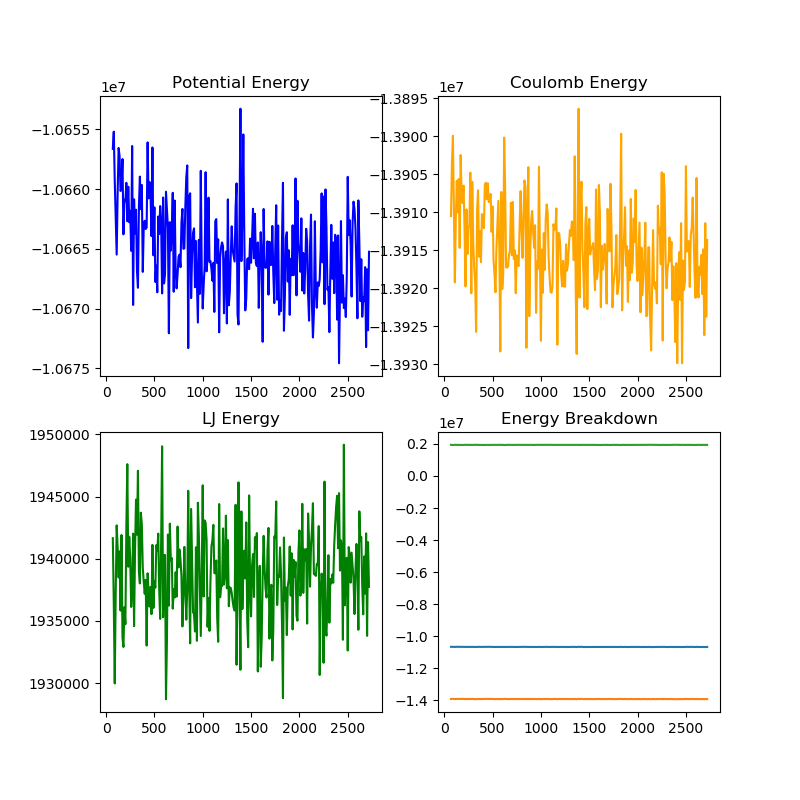

Text(0.5,1,'Energy Breakdown')

In [31]:
from matplotlib import pyplot as plt
%matplotlib notebook
project = signac.get_project()
with project.open_job(id = '73bca') as job:
    potential_higher = np.genfromtxt('potential_md.xvg')
    coulomb_higher = np.genfromtxt('coulomb_md.xvg')
    lj_higher = np.genfromtxt('lj_md.xvg')
with project.open_job(id = 'a891a') as job:
    potential_lower = np.genfromtxt('potential_md.xvg')
    coulomb_lower = np.genfromtxt('coulomb_md.xvg')
    lj_lower = np.genfromtxt('lj_md.xvg')
    
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
start_index = 7

axes[0, 0].plot(potential_lower[start_index:, 0], potential_lower[start_index:, 1],
                label='Potential 0.02', color='blue')
axes[0, 0].set_title('Potential Energy')
axes[0, 1].plot(coulomb_lower[start_index:, 0], coulomb_lower[start_index:, 1],
                label='Coulomb 0.02', color='orange')
axes[0, 1].set_title('Coulomb Energy')
axes[1, 0].plot(lj_lower[start_index:, 0], lj_lower[start_index:, 1],
                label = 'LJ 0.02', color='green')
axes[1, 0].set_title('LJ Energy')
axes[1, 1].plot(potential_lower[start_index:, 0], potential_lower[start_index:, 1], label = 'Potential 0.02')
axes[1, 1].plot(coulomb_lower[start_index:, 0], coulomb_lower[start_index:, 1], label = 'Coulomb 0.02')
axes[1, 1].plot(lj_lower[start_index:, 0], lj_lower[start_index:, 1], label = 'LJ 0.02')
axes[1, 1].set_title('Energy Breakdown')